# Template Matching Chord Recogniser
Application that tries to recognise chords from a selected music file.

In [1]:
#Import valuable libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import librosa
import librosa.display as dspl
import librosa.feature as feat

from tkinter import filedialog
from tkinter import *

import ntpath

import sounddevice as sd

import pandas as pd

from sklearn import neighbors

#Only for icon in windows, comment if it rises problems
import ctypes

myappid = 'maccarini.templatematching.chord.0' # arbitrary string
ctypes.windll.shell32.SetCurrentProcessExplicitAppUserModelID(myappid)

0

In [2]:
major_labs=["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"]
minor_labs=["C:min","C#:min","D:min","D#:min","E:min","F:min","F#:min","G:min","G#:min","A:min","A#:min","B:min"]
dominant7_labs=["C:7","C#:7","D:7","D#:7","E:7","F:7","F#:7","G:7","G#:7","A:7","A#:7","B:7"]
major7_labs=["C:maj7","C#:maj7","D:maj7","D#:maj7","E:maj7","F:maj7","F#:maj7","G:maj7","G#:maj7","A:maj7","A#:maj7","B:maj7"]
minor7_labs=["C:min7","C#:min7","D:min7","D#:min7","E:min7","F:min7","F#:min7","G:min7","G#:min7","A:min7","A#:min7","B:min7"]
chroma_labs=["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"]

#Chroma representation of a note (root) with harmonics
def chroma_note_harmonics(root,alpha):
    model=np.array([1+alpha+alpha**3+alpha**7,
                   0,
                   0,
                   0,
                   alpha**4,
                   0,
                   0,
                   alpha**2+alpha**5,
                   0,
                   0,
                   alpha**6,
                   0])
    chroma=np.roll(model, root)
    return chroma

# Chroma representation of chords with harmonics
def chroma_chords(alpha,major=True,minor=True,dominant7=False,major7=False,minor7=False):
    chords=np.zeros(shape=(12,major*12+minor*12+dominant7*12+major7*12+minor7*12))
    labs=[]
    for i in range(12): #loop on possible root notes
        if major:
            chords[:,i]=chroma_note_harmonics(root=i,alpha=alpha)+chroma_note_harmonics(root=i+4,alpha=alpha)+chroma_note_harmonics(root=i+7,alpha=alpha)
            if i==0:
                labs=labs+major_labs
        if minor:
            chords[:,major*12+i]=chroma_note_harmonics(root=i,alpha=alpha)+chroma_note_harmonics(root=i+3,alpha=alpha)+chroma_note_harmonics(root=i+7,alpha=alpha)
            if i==0:
                labs=labs+minor_labs
        if dominant7:
            chords[:,major*12+minor*12+i]=chroma_note_harmonics(root=i,alpha=alpha)+chroma_note_harmonics(root=i+4,alpha=alpha)+chroma_note_harmonics(root=i+7,alpha=alpha)+chroma_note_harmonics(root=i+10,alpha=alpha)
            if i==0:
                labs=labs+dominant7_labs
        if major7:
            chords[:,major*12+minor*12+dominant7*12+i]=chroma_note_harmonics(root=i,alpha=alpha)+chroma_note_harmonics(root=i+4,alpha=alpha)+chroma_note_harmonics(root=i+7,alpha=alpha)+chroma_note_harmonics(root=i+11,alpha=alpha)
            if i==0:
                labs=labs+major7_labs
        if minor7:
            chords[:,major*12+minor*12+dominant7*12+major7*12+i]=chroma_note_harmonics(root=i,alpha=alpha)+chroma_note_harmonics(root=i+3,alpha=alpha)+chroma_note_harmonics(root=i+7,alpha=alpha)+chroma_note_harmonics(root=i+10,alpha=alpha)
            if i==0:
                labs=labs+minor7_labs
    return (chords,labs)

def normalize_2(chroma):
    s=np.sum(chroma**2,axis=0)
    for i in range(len(s)):
        if s[i]>0:
            chroma[:,i]=chroma[:,i]/np.sqrt(s[i])
    return chroma

# Settings
hop_length=2048
n_fft=2048

In [3]:
# Select the file to analyze
root = Tk()
root.iconphoto(False, PhotoImage(file='icons/play.png'))
root.filename =  filedialog.askopenfilename(initialdir = "Chord Examples",title = "Select an audio file",filetypes = (("all files","*.*"),("mp3","*.mp3"),("wav","*.wav")))
if(root.filename):
    #print ("Selected file path:",root.filename)
    name=ntpath.basename(root.filename)
    print ("Selected file name:",name)
else:
    print ("Please select a file!")
root.destroy()

Selected file name: Guitar Example 02 - (C#, C, Fm, D#).wav


Sampling rate: 22050


Text(0.5, 1.0, 'Chroma representation')

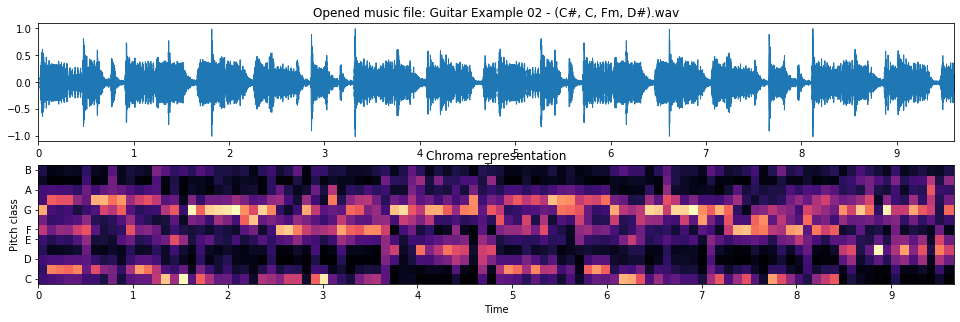

In [4]:
# Loading file with librosa
music,sr=librosa.load(root.filename)
chroma=normalize_2(feat.chroma_stft(y=music,sr=sr,norm=2,hop_length=hop_length,n_fft=n_fft,tuning=0,octwidth=None))
# WARNING: You need to have ffmpeg insalled in order to open mp3 files
# If you are using conda/anaconda runnig the following in the command prompt should fix the problem:
# conda install -c conda-forge ffmpeg
print("Sampling rate:",sr)
# Plotting waveform (just because) and chroma    
plt.figure(figsize=(16.4, 4.8))
plt.subplot(2,1,1)
dspl.waveplot(music,sr)
plt.title("Opened music file: "+name)
plt.subplot(2,1,2)
dspl.specshow(chroma, y_axis='chroma', x_axis='time',hop_length=hop_length)
plt.title("Chroma representation")

In [5]:
# Play audio
sd.play(music, sr)

In [6]:
# Ok! Stop it!
sd.stop()

In [7]:
# Functions
def temporal_smothing(chroma,n_win):
    chroma_sm=np.zeros(shape=chroma.shape)
    chr_pd=librosa.util.pad_center(chroma,chroma.shape[1]+n_win, axis=1)
    for n in range(chroma.shape[1]):
        chroma_sm[:,n]=np.sum(chr_pd[:,n:(n+n_win)],axis=1)*1/n_win
    return chroma_sm

def template_matching(chroma,chords):
    nvals=chroma.shape[1]
    nchords=chords.shape[1]
    est_chords=np.zeros(shape=nvals,dtype=int)
    est_dist=np.zeros(shape=nvals)
    dist=np.zeros(shape=nchords)
    for i in range(nvals):
        for ch in range(nchords):
            dist[ch]=np.linalg.norm(chroma[:,i]-chords[:,ch])
            est_chords[i]=np.argmin(dist)
            est_dist[i]=np.min(dist)
    return (est_chords,est_dist)

def write_lab_file(name,est_chords,sr,hop_length,chords_labs):
    file = open(name+".lab","w")
    beg=0
    end=0
    curr=est_chords[0]
    N_chords=1
    for i in range(len(est_chords)):
        if est_chords[i] != curr:
            end=i
            file.write(str(librosa.frames_to_time(beg, sr=sr, hop_length=hop_length))+" "+str(librosa.frames_to_time(end, sr=sr, hop_length=hop_length))+" "+chords_labs[curr]+"\n")
            beg=i
            curr=est_chords[i]
            N_chords=N_chords+1
    end=len(est_chords)
    file.write(str(librosa.frames_to_time(beg, sr=sr, hop_length=hop_length))+" "+str(librosa.frames_to_time(end, sr=sr, hop_length=hop_length))+" "+chords_labs[curr]+"\n")
    file.close()
    #print(name+".lab"+" saved in \"Analyzed_tracks/\"")
    print("Saved "+str(N_chords)+" chords to file")

def n_different_chords(est_chords):
    curr=est_chords[0]
    N_chords=1
    for i in range(len(est_chords)):
        if est_chords[i] != curr:
            curr=est_chords[i]
            N_chords=N_chords+1
    return N_chords

def estimation_error(est_chords,annotated_chords):
    if len(est_chords)==len(annotated_chords):
        return sum(est_chords!=annotated_chords)/len(est_chords)
    else:
        print("ERROR: different lengths!")
        return None
    
# Load reference annotations
def read_lab_file(path,n_frames,sr,hop_length):
    df_curr=pd.read_csv(path,sep=" ",names=["start","end","chord"])
    row=0
    chords=[]
    for i in range(n_frames):
        curr=librosa.frames_to_time(i, sr=sr, hop_length=hop_length)
        if curr<df_curr["end"][row]:
            chords.append(df_curr["chord"][row])
        else:
            while curr>=df_curr["end"][row] and row < len(df_curr)-1:
                row=row+1
            chords.append(df_curr["chord"][row])
    return chords

def estimate_chords(music_input,template_chords,mu=False,n_win=False,post_smoothing=False):# can add also postprocessing features
    if type(music_input)==str:
        # open the file
        music,sr=librosa.load(music_input)
        # compute the chroma
        chroma=feat.chroma_stft(y=music,sr=sr,norm=2,hop_length=hop_length,n_fft=n_fft,tuning=0,octwidth=None)
    else: # music_input must be np.ndarry
        chroma=music_input
    # preprocessing:
    if mu: # compression
        chroma = librosa.mu_compress(chroma, quantize=False, mu=mu)
    if n_win: # temporal smoothing
        chroma=temporal_smothing(chroma,n_win=n_win)
    # normalize
    chroma=normalize_2(chroma)
    # template matching
    estimated,distance=template_matching(chroma,template_chords)
    # postprocessing
    if post_smoothing:
        clf = neighbors.KNeighborsClassifier(post_smoothing, weights='uniform')
        clf.fit(np.arange(len(estimated)).reshape(-1, 1),estimated)
        estimated = clf.predict(np.arange(len(estimated)).reshape(-1, 1))
    
    return estimated

def time_chord(est_chords,sr,hop_length,chords_labs):
    times=[]
    chords=[]
    beg=0
    end=0
    curr=est_chords[0]
    N_chords=1
    for i in range(len(est_chords)):
        if est_chords[i] != curr:
            end=i
            times.append(librosa.frames_to_time(beg, sr=sr, hop_length=hop_length))
            chords.append(chords_labs[curr])
            beg=i
            curr=est_chords[i]
            N_chords=N_chords+1
    end=len(est_chords)
    times.append(librosa.frames_to_time(beg, sr=sr, hop_length=hop_length))
    chords.append(chords_labs[curr])
    return (times,chords)

def omologous(root):
    flats=["Cb","Db","Eb","Fb","Gb","Ab","Bb"]
    omo=["B","C#","D#","E","F#","G#","A#"]
    if root in flats:
        return omo[flats.index(root)]
    else:
        return root
    
def chord_to_triad(lab):
    triads_labs=["C","C#","D","D#","E","F","F#","G","G#","A","A#","B","C:min","C#:min","D:min","D#:min","E:min","F:min","F#:min","G:min","G#:min","A:min","A#:min","B:min"]
    separated_lab=lab.split(":")
    n=len(separated_lab)
    if n==1:
        return omologous(lab.split("/")[0])
    else:
        root=separated_lab[0]
        if separated_lab[1][0].isdigit():
            return omologous(root.split("/")[0])
        elif separated_lab[1][:3]=="min" or separated_lab[1][:3]=="dim":
            return omologous(root.split("/")[0])+":min"
        else:
            return omologous(root.split("/")[0])

In [8]:
# Settings
alpha=0.2 # parameter for harmonics in template
mu=40 # compression parameter
n_win=5 # temporal smoothing (preprocessing)
post_smoothing=15 # knn smoothing (postprocesing)

In [9]:
chords,chords_labs=chroma_chords(alpha)
estimated=estimate_chords(music_input=chroma,template_chords=chords,mu=mu,n_win=n_win,post_smoothing=post_smoothing)

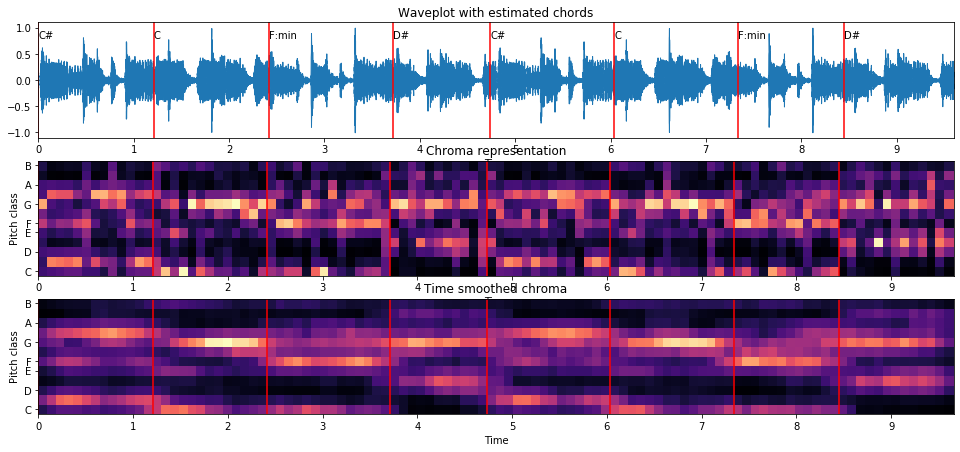

In [10]:
chroma_smooth=temporal_smothing(chroma,n_win=n_win)

plt.figure(figsize=(16.4, 2.4*3))
plt.subplot(3,1,1)
dspl.waveplot(music,sr)
plt.title("Waveplot with estimated chords")
for ii in range(len(time_chord(estimated,sr,hop_length,chords_labs)[0])):
    plt.axvline(x=time_chord(estimated,sr,hop_length,chords_labs)[0][ii], ymin=0, ymax=1,c='r')
    plt.text(time_chord(estimated,sr,hop_length,chords_labs)[0][ii], 0.8*max(abs(music)),time_chord(estimated,sr,hop_length,chords_labs)[1][ii] )

plt.subplot(3,1,2)
dspl.specshow(chroma, y_axis='chroma', x_axis='time',hop_length=hop_length)
plt.title("Chroma representation")
for t in time_chord(estimated,sr,hop_length,chords_labs)[0]:
    plt.axvline(x=t, ymin=0, ymax=1,c='r')

plt.subplot(3,1,3)
dspl.specshow(chroma_smooth, y_axis='chroma', x_axis='time',hop_length=hop_length)
plt.title("Time smoothed chroma")
for t in time_chord(estimated,sr,hop_length,chords_labs)[0]:
    plt.axvline(x=t, ymin=0, ymax=1,c='r')

In [11]:
write_lab_file(name="Analyzed_tracks/"+name,est_chords=estimated,sr=sr,hop_length=hop_length,chords_labs=chords_labs)

Saved 8 chords to file


## Error evaluation
If you have a reference annotation file .lab with the correct chords as annotated by a music expert, you can load it here and check the error made by the classifier.

In [12]:
# Select .lab file
root = Tk()
root.iconphoto(False, PhotoImage(file='icons/play.png'))
root.filename =  filedialog.askopenfilename(initialdir = "Chord Examples",title = "Select an annotations file",filetypes = (("lab","*.lab"),("csv","*.csv"),("all files","*.*")))
if(root.filename):
    #print ("Selected file path:",root.filename)
    name=ntpath.basename(root.filename)
    print ("Selected file name:",name)
else:
    print ("Please select a file!")
root.destroy()

Selected file name: Guitar Example 02 - (C#, C, Fm, D#).lab


In [13]:
chord_reference_literal=read_lab_file(path=root.filename,n_frames=chroma.shape[1],sr=sr,hop_length=hop_length)
chord_reference_literal_reduced=[]
for ii in range(len(chord_reference_literal)):
    chord_reference_literal_reduced.append(chord_to_triad(chord_reference_literal[ii]))
ref_annotations=[]
chords_labs.append('N')
for ii in range(len(chord_reference_literal_reduced)):
    ref_annotations.append(chords_labs.index(chord_reference_literal_reduced[ii]))

Text(0.5, 1.0, 'Estimated chord label vs time frame')

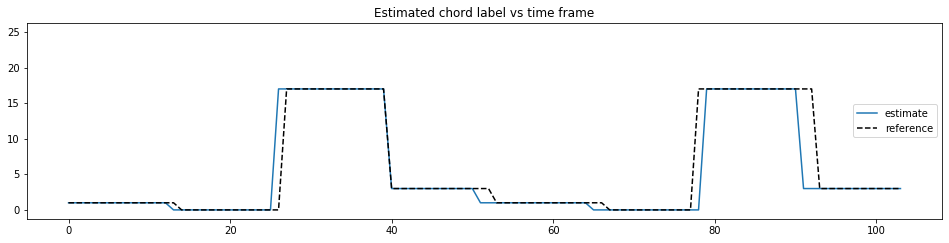

In [14]:
plt.figure(figsize=(16.4, 3.6))
plt.plot(len(chords_labs)*np.ones(shape=len(ref_annotations)),'w--')
plt.plot(estimated,label='estimate')
plt.plot(ref_annotations,'k--',label="reference")
plt.legend()
plt.title("Estimated chord label vs time frame")

In [15]:
error=estimation_error(estimated,ref_annotations)
N_chords=n_different_chords(estimated)
N_chords_annotation=n_different_chords(ref_annotations)
print("Resuls of the estimation")
print("Expected",N_chords_annotation,"chords,\tEstimated",N_chords,"chords")
print("Error:",str(error)[:5])

Resuls of the estimation
Expected 8 chords,	Estimated 8 chords
Error: 0.086
